# Deep learning for timeseries

### Reference: Deep Learning with Python, 2nd Edition Chapter 11

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

***Download climate data***

In [3]:
#!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
#unzip jena_climate_2009_2016.csv.zip

In [4]:
df = pd.read_csv("data/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
print(df.shape)
df.describe()

(420451, 15)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [7]:
# drop the Date Time column
df.drop(['Date Time'], axis=1, inplace = True)
df.shape

(420451, 14)

In [8]:
temperature = df['T (degC)'].values

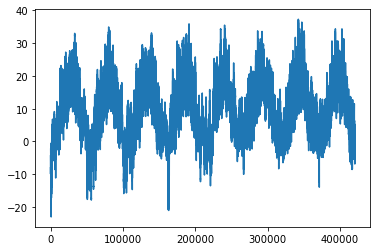

In [9]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

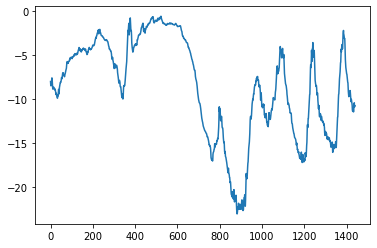

In [10]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [11]:
n = df.shape[0]
num_train_samples = int(0.5 * n)
num_val_samples = int(0.25 * n)
num_test_samples = n - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [12]:
raw_data = df.values
print(raw_data.shape)
type(raw_data)

(420451, 14)


numpy.ndarray

In [13]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [14]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [15]:
std

array([ 8.50510865,  8.77098361,  8.86560463,  7.08011256, 16.62877917,
        7.6012955 ,  4.14689697,  4.76961017,  2.63277288,  4.1996886 ,
       42.0392747 ,  1.53358803,  2.32305586, 85.85032063])

In [16]:
mean

array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

**Instantiating datasets for training, validation, and testing**

In [17]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

delay

858

In [18]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [19]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.29
Test MAE: 10.39


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [107]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 0.6205 - mae: 0.5351 - val_loss: 0.2631 - val_mae: 0.4192
Epoch 2/10
819/819 [==============================] - 21s 26ms/step - loss: 0.1528 - mae: 0.3048 - val_loss: 0.1343 - val_mae: 0.2903
Epoch 3/10
819/819 [==============================] - 21s 25ms/step - loss: 0.1163 - mae: 0.2679 - val_loss: 0.1318 - val_mae: 0.2873
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 0.1045 - mae: 0.2540 - val_loss: 0.1573 - val_mae: 0.3133
Epoch 5/10
819/819 [==============================] - 21s 25ms/step - loss: 0.0983 - mae: 0.2465 - val_loss: 0.1361 - val_mae: 0.2915
Epoch 6/10
819/819 [==============================] - 20s 25ms/step - loss: 0.0940 - mae: 0.2409 - val_loss: 0.1552 - val_mae: 0.3125
Epoch 7/10
819/819 [==============================] - 21s 25ms/step - loss: 0.0910 - mae: 0.2372 - val_loss: 0.1461 - val_mae: 0.3023
Epoch 8/10
819/819 [==============================] - 20s 25ms

**Plotting results**

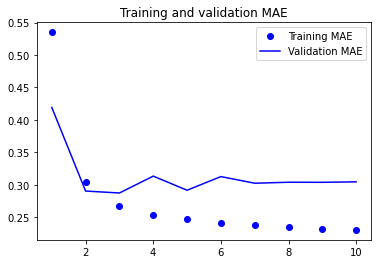

In [108]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [109]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 0.2317 - mae: 0.3795 - val_loss: 0.2093 - val_mae: 0.3569
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 0.1704 - mae: 0.3273 - val_loss: 0.2595 - val_mae: 0.4076
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 0.1540 - mae: 0.3107 - val_loss: 0.2060 - val_mae: 0.3564
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 0.1436 - mae: 0.2995 - val_loss: 0.1937 - val_mae: 0.3465
Epoch 5/10
819/819 [==============================] - 42s 52ms/step - loss: 0.1366 - mae: 0.2919 - val_loss: 0.1931 - val_mae: 0.3461
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 0.1303 - mae: 0.2851 - val_loss: 0.2027 - val_mae: 0.3521
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 0.1257 - mae: 0.2799 - val_loss: 0.1995 - val_mae: 0.3498
Epoch 8/10
819/819 [==============================] - 44s 54ms

### A first recurrent baseline

**A simple LSTM-based model**

In [110]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 77s 92ms/step - loss: 0.1500 - mae: 0.2980 - val_loss: 0.1166 - val_mae: 0.2658
Epoch 2/10
819/819 [==============================] - 76s 92ms/step - loss: 0.1181 - mae: 0.2691 - val_loss: 0.1195 - val_mae: 0.2693
Epoch 3/10
819/819 [==============================] - 80s 98ms/step - loss: 0.1091 - mae: 0.2594 - val_loss: 0.1218 - val_mae: 0.2705
Epoch 4/10
819/819 [==============================] - 77s 94ms/step - loss: 0.1033 - mae: 0.2525 - val_loss: 0.1255 - val_mae: 0.2742
Epoch 5/10
819/819 [==============================] - 76s 92ms/step - loss: 0.0985 - mae: 0.2466 - val_loss: 0.1286 - val_mae: 0.2783
Epoch 6/10
819/819 [==============================] - 79s 96ms/step - loss: 0.0944 - mae: 0.2414 - val_loss: 0.1300 - val_mae: 0.2816
Epoch 7/10
819/819 [==============================] - 78s 95ms/step - loss: 0.0910 - mae: 0.2366 - val_loss: 0.1354 - val_mae: 0.2880
Epoch 8/10
819/819 [==============================] - 77s 94ms

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [111]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [112]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [113]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [114]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [115]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [116]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 241s 292ms/step - loss: 0.1842 - mae: 0.3338 - val_loss: 0.1186 - val_mae: 0.2681
Epoch 2/20
819/819 [==============================] - 236s 288ms/step - loss: 0.1647 - mae: 0.3156 - val_loss: 0.1126 - val_mae: 0.2601
Epoch 3/20
819/819 [==============================] - 237s 289ms/step - loss: 0.1597 - mae: 0.3110 - val_loss: 0.1164 - val_mae: 0.2654
Epoch 4/20
819/819 [==============================] - 234s 285ms/step - loss: 0.1550 - mae: 0.3070 - val_loss: 0.1136 - val_mae: 0.2623
Epoch 5/20
819/819 [==============================] - 233s 285ms/step - loss: 0.1525 - mae: 0.3043 - val_loss: 0.1110 - val_mae: 0.2591
Epoch 6/20
819/819 [==============================] - 232s 283ms/step - loss: 0.1500 - mae: 0.3015 - val_loss: 0.1127 - val_mae: 0.2606
Epoch 7/20
819/819 [==============================] - 233s 284ms/step - loss: 0.1479 - mae: 0.2995 - val_loss: 0.1124 - val_mae: 0.2600
Epoch 8/20
819/819 [============================

In [25]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

In [117]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 266s 318ms/step - loss: 0.1934 - mae: 0.3389 - val_loss: 0.1241 - val_mae: 0.2759
Epoch 2/20
819/819 [==============================] - 281s 343ms/step - loss: 0.1618 - mae: 0.3135 - val_loss: 0.1236 - val_mae: 0.2756
Epoch 3/20
819/819 [==============================] - 264s 322ms/step - loss: 0.1573 - mae: 0.3084 - val_loss: 0.1115 - val_mae: 0.2594
Epoch 4/20
819/819 [==============================] - 257s 314ms/step - loss: 0.1521 - mae: 0.3036 - val_loss: 0.1103 - val_mae: 0.2572
Epoch 5/20
819/819 [==============================] - 257s 314ms/step - loss: 0.1483 - mae: 0.3003 - val_loss: 0.1178 - val_mae: 0.2667
Epoch 6/20
819/819 [==============================] - 258s 315ms/step - loss: 0.1438 - mae: 0.2961 - val_loss: 0.1215 - val_mae: 0.2713
Epoch 7/20
819/819 [==============================] - 263s 321ms/step - loss: 0.1399 - mae: 0.2921 - val_loss: 0.1162 - val_mae: 0.2643
Epoch 8/20
819/819 [============================

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Try 10 epochs to save time
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 116s 138ms/step - loss: 0.1585 - mae: 0.2973 - val_loss: 0.1190 - val_mae: 0.2655
Epoch 2/10
819/819 [==============================] - 121s 147ms/step - loss: 0.1025 - mae: 0.2512 - val_loss: 0.1249 - val_mae: 0.2731
Epoch 3/10
819/819 [==============================] - 131s 159ms/step - loss: 0.0895 - mae: 0.2347 - val_loss: 0.1327 - val_mae: 0.2833
Epoch 4/10
819/819 [==============================] - 124s 151ms/step - loss: 0.0817 - mae: 0.2241 - val_loss: 0.1335 - val_mae: 0.2850
Epoch 5/10
819/819 [==============================] - 119s 145ms/step - loss: 0.0763 - mae: 0.2165 - val_loss: 0.1399 - val_mae: 0.2904
Epoch 6/10
819/819 [==============================] - 118s 144ms/step - loss: 0.0721 - mae: 0.2104 - val_loss: 0.1436 - val_mae: 0.2949
Epoch 7/10
819/819 [==============================] - 165s 201ms/step - loss: 0.0682 - mae: 0.2045 - val_loss: 0.1501 - val_mae: 0.3016
Epoch 8/10
819/819 [============================

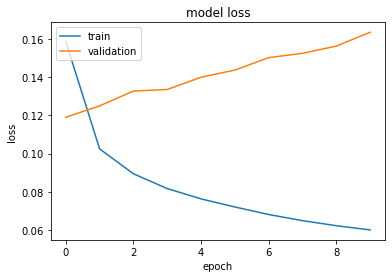

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Going even further

## Summary